# Fraud Detection - Isolation Forest

#### https://dl.acm.org/citation.cfm?id=1511387, https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/icdm08b.pdf

Isolation Forest or iForest, builds an ensemble of iTrees for a given data set, then anomalies are those instances which have short average path lengths on the iTrees. There are only two variables in this method: the number of trees to build and the sub-sampling size. iForest’s detection performance converges quickly with a very small number of trees, and it only requires a small sub-sampling size to achieve high detection performance with high efficiency.

In [48]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

from sklearn import svm

from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn import svm
from sklearn.neighbors import NearestNeighbors

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, roc_curve, auc, precision_score, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix
from sklearn.metrics import average_precision_score

import scikitplot as skplt
%matplotlib inline

In [2]:
credit = pd.read_csv("D:\Projects\Kaggle\Fraud Detection\creditcard.csv")

In [3]:
credit.isnull().sum()[credit.isnull().sum()>0]

Series([], dtype: int64)

<h1>Exploring the Dataset</h1>

From the above it could be infered that the dataset has 28 anonymized features and 2 non anonymized features i) Amount and ii) Class (whether the transcation was a fraud or not) 

In [4]:
credit.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [5]:
Fraud = credit[credit['Class']==1]
NFraud = credit[credit['Class']==0]

In [6]:
print((len(Fraud)/len(NFraud))*100,"%")

0.17304750013189596 %


In [21]:
outlier = len(Fraud)/len(NFraud)
print(outlier)

0.0017304750013189597


In [9]:
credit.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

It can infered that the datset is skewed with just 0.17274% fradulent examples. One could simply get a overall accuracy of 99.82726% by predicting every example isnt a fradulent example. But, the approach does not solve the problem. So recall rate (True positives/(True Positives+False Negatives)) would be the metric to optimize.  

# Isolation Forest and Local Outlier Factor

Reference https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/icdm08b.pdf

In [7]:
i_data = credit.copy()

In [10]:
X = i_data.drop('Class', axis=1)
y = i_data.Class

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=11)
print (X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(190820, 30) (190820,) (93987, 30) (93987,)


In [46]:
def metrics_calc(actual, predicted, predicted_prob):
    # Compute confusion matrix
    cm = confusion_matrix(actual, predicted)
    TP = cm[1,1]
    TN = cm[0,0]
    FN = cm[1,0]
    FP = cm[0,1]
    accuracy = (TP+TN)/(TP+FP+TN+FN)
    miscalc_rate = (FP+FN)/(TP+FP+TN+FN)
    tpr = TP/(TP+FN)
    fpr = FP/(FP+TN)
    ppv = TP/(TP+FP)
    prevalence = TP/(TP+FP+TN+FN)  
    null_accuracy = max(predicted.mean(), 1 - predicted.mean())
    f1_score = 2 * (ppv*tpr)/(ppv+tpr)               


    # calculate precision-recall curve
    precision, recall, thresholds = precision_recall_curve(actual, predicted_prob)
    # calculate precision-recall AUC
    area_under_curve = auc(recall, precision)
    # calculate average precision score
    av_pr_score = average_precision_score(actual, predicted)
    print('-------------------------------------')
    print('Recall (TPR) = ', tpr)
    print('Fallout (FPR) = ', fpr)
    print('Precision (PPV) = ', ppv)
    print('F1 Score = ', f1_score)
    print('Area Under Curve = ', area_under_curve)
    print('Average Precision Score', av_pr_score)    
    print('-------------------------------------')
    print('Accuracy = ', accuracy)
    print('null_accuracy = ', null_accuracy)
    print('miscalc_rate = ',miscalc_rate)    

    
    return fpr, tpr, area_under_curve

## Isolation Forest

In [62]:
if_clf = IsolationForest(n_estimators=100, max_samples=.30, contamination=outlier, random_state=11, n_jobs=-1)

In [63]:
if_clf.fit(X_train, y_train)
train_if_pred = if_clf.predict(X_train)
test_if_pred = if_clf.predict(X_test)

D:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [64]:
train_if_scores = if_clf.decision_function(X_train)
test_if_scores = if_clf.decision_function(X_test)

In [85]:
# Anamolies are with class = -1. Change to 1 and 0 for our fraud classes
train_if_pred[train_if_pred == 1] = 0
train_if_pred[train_if_pred == -1] = 1

test_if_pred[test_id_pred == 1] = 0
test_if_pred[test_id_pred == -1] = 1

In [87]:
metrics_calc(y_test, test_if_pred, test_if_scores)

-------------------------------------
Recall (TPR) =  0.3050847457627119
Fallout (FPR) =  0.0013005010126852148
Precision (PPV) =  0.3068181818181818
F1 Score =  0.3059490084985836
Area Under Curve =  0.0009522151976439698
Average Precision Score 0.09491423862294303
-------------------------------------
Accuracy =  0.9973932565141987
null_accuracy =  0.998127400597955
miscalc_rate =  0.0026067434858012277


(0.0013005010126852148, 0.3050847457627119, 0.0009522151976439698)

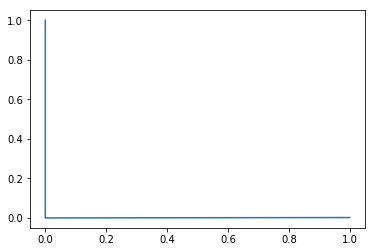

In [89]:
precision, recall, thresholds = precision_recall_curve(test_if_pred, test_if_scores)

plt.plot(recall, precision)
plt.show()

In [90]:
print('Confusion Matrix: \n', confusion_matrix(y_test, test_if_pred))
print('Classification Report: \n', classification_report(y_test, test_if_pred))

Confusion Matrix: 
 [[93688   122]
 [  123    54]]
Classification Report: 
              precision    recall  f1-score   support

          0       1.00      1.00      1.00     93810
          1       0.31      0.31      0.31       177

avg / total       1.00      1.00      1.00     93987



In [86]:
pd.crosstab(y_test, test_if_pred, colnames=['Predicted'], margins=True)

Predicted,0,1,All
Class,,,
0,93688,122,93810
1,123,54,177
All,93811,176,93987


### Observation

There were total of 93987 transactions in test dataset. This included 93810 non fraud and 177 fraud.
- True Positive(TP) : Out of 93810 normal txns, 93688 were correctly predicted as NORMAL
- False Negative (FN) : Out of 93810 normal txns, 122 were incorrectly predicted as FRAUD. 
- False Positive (FP) : Out of 177 fraudulent txns, 123 were incorrectly predicted as NORMAL
- True Negative (TN) : Out of 177 fraudulent txns, 54 were correctly predicted as FRAUD. 

### Isolation Forest dont seem to have improved result for detecting anamolies in this specific data

## Local Outlier Factor

In [62]:
lof_clf = LocalOutlierFactor(n_neighbors=5, metric='euclidean', algorithm='auto', contamination=outlier, n_jobs=-1)

In [72]:
train_lof_pred = lof_clf.fit_predict(X_train)
train_lof_scores = lof_clf.negative_outlier_factor_

In [74]:
test_lof_pred = lof_clf.fit_predict(X_test)
test_lof_scores = lof_clf.negative_outlier_factor_

In [81]:
# Anamolies are with class = -1. Change to 1 and 0 for our fraud classes
train_lof_pred[train_lof_pred == 1] = 0
train_lof_pred[train_lof_pred == -1] = 1

test_lof_pred[test_lof_pred == 1] = 0
test_lof_pred[test_lof_pred == -1] = 1

In [91]:
errors = (test_lof_pred != y_test).sum()
print('LOF errors (Actual != Predicted):', errors)

LOF errors (Actual != Predicted): 322


In [92]:
pd.crosstab(y_test, test_lof_pred, colnames=['Predicted'], margins=True)

Predicted,0,1,All
Class,,,
0,93656,154,93810
1,168,9,177
All,93824,163,93987


In [93]:
metrics_calc(y_test, test_lof_pred, test_lof_scores)

-------------------------------------
Recall (TPR) =  0.05084745762711865
Fallout (FPR) =  0.001641616032405927
Precision (PPV) =  0.05521472392638037
F1 Score =  0.052941176470588235
Area Under Curve =  0.001127772902139552
Average Precision Score 0.004595009582646236
-------------------------------------
Accuracy =  0.9965739942758041
null_accuracy =  0.9982657175992424
miscalc_rate =  0.0034260057241958996


(0.001641616032405927, 0.05084745762711865, 0.001127772902139552)

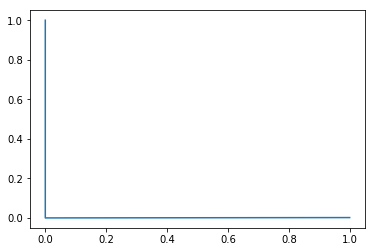

In [94]:
precision, recall, thresholds = precision_recall_curve(test_lof_pred, test_lof_scores)

plt.plot(recall, precision)
plt.show()

In [95]:
print('Confusion Matrix: \n', confusion_matrix(y_test, test_lof_pred))
print('Classification Report: \n', classification_report(y_test, test_lof_pred))

Confusion Matrix: 
 [[93656   154]
 [  168     9]]
Classification Report: 
              precision    recall  f1-score   support

          0       1.00      1.00      1.00     93810
          1       0.06      0.05      0.05       177

avg / total       1.00      1.00      1.00     93987



In [96]:
pd.crosstab(y_test, test_lof_pred, colnames=['Predicted'], margins=True)

Predicted,0,1,All
Class,,,
0,93656,154,93810
1,168,9,177
All,93824,163,93987


### Observation

There were total of 93987 transactions in test dataset. This included 93810 non fraud and 177 fraud.
- True Positive(TP) : Out of 93810 normal txns, 93656 were correctly predicted as NORMAL
- False Negative (FN) : Out of 93810 normal txns, 154 were incorrectly predicted as FRAUD. 
- False Positive (FP) : Out of 177 fraudulent txns, 168 were incorrectly predicted as NORMAL
- True Negative (TN) : Out of 177 fraudulent txns, 9 were correctly predicted as FRAUD. 

### Local Outlier Factor is performing worse than Isolation Forest - especially in identifying fraud transactions (anamolies) and in also incorrectly predicting fraud txns as normal.

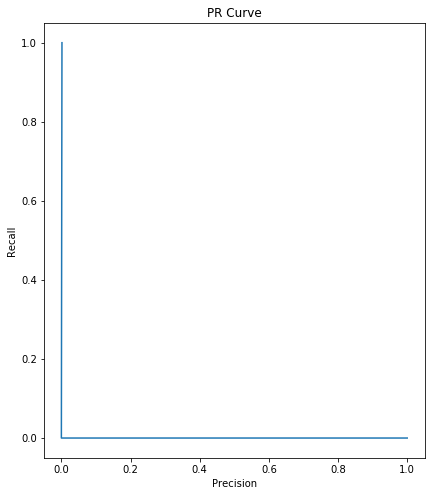

In [100]:
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlabel('Precision')
ax1.set_ylabel('Recall')
ax1.set_title('PR Curve')
ax1.plot(precision, recall)
